In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import os
from google.colab import files
import zipfile
import shutil

In [2]:
print("Upload your dataset ZIP file:")
uploaded_dataset = files.upload()  # Upload ZIP containing folder structure
dataset_zip = list(uploaded_dataset.keys())[0]

Upload your dataset ZIP file:


Saving straw.zip to straw.zip


In [3]:
import zipfile
import os

# Extract the uploaded ZIP file
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # You can change "dataset" to your preferred folder name

print("Dataset extracted successfully to 'dataset/' folder.")

Dataset extracted successfully to 'dataset/' folder.


In [4]:
base_path = '/content/dataset/straw'
splits = ['test', 'train', 'valid']
classes = ['ripe','turning','unripe']

In [5]:
for cls in classes:
    target_dir = os.path.join(base_path, cls)
    os.makedirs(target_dir, exist_ok=True)

    for split in splits:
        src_dir = os.path.join(base_path, split, cls)
        if not os.path.exists(src_dir):
            continue

        #MOVING EACH FILE
        for file in os.listdir(src_dir):
            src = os.path.join(src_dir, file)
            dst = os.path.join(target_dir, file)
            shutil.move(src, dst)


        try:
            os.rmdir(src_dir)
        except:
            pass


for split in splits:
    split_dir = os.path.join(base_path, split)
    try:
        os.rmdir(split_dir)
    except:
        pass

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#NORMALIZATION
image_size = (224, 224)
batch_size = 32
data_dir = '/content/dataset/straw'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values
    horizontal_flip=True,        # flip images left-right
    vertical_flip=True,          # flip images up-down (good if strawberries are in any orientation)
    rotation_range=30,           # rotate images up to ±30°
    zoom_range=0.3,              # zoom in/out by up to 30%
    width_shift_range=0.15,      # shift image horizontally by up to 15%
    height_shift_range=0.15,     # shift image vertically by up to 15%
    brightness_range=[0.8, 1.2], # randomly change brightness
    shear_range=0.2,             # shear transformation for perspective shift
    fill_mode='nearest',         # fill in empty pixels after transformation
    validation_split=0.2         # reserve 20% for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True                 # make sure images are shuffled
)

val_datagen = ImageDataGenerator(
    rescale=1./255,              # only normalization for validation
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1208 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

#ADDING CLASSIFICATION LAYER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
outputs = Dense(3, activation='softmax',kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_generator, validation_data=val_generator, epochs=35)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 808ms/step - accuracy: 0.2980 - loss: 1.6290 - val_accuracy: 0.6977 - val_loss: 0.9551
Epoch 2/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 474ms/step - accuracy: 0.6559 - loss: 1.0364 - val_accuracy: 0.8140 - val_loss: 0.7365
Epoch 3/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 451ms/step - accuracy: 0.8113 - loss: 0.7984 - val_accuracy: 0.8472 - val_loss: 0.6418
Epoch 4/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 474ms/step - accuracy: 0.8533 - loss: 0.6963 - val_accuracy: 0.8771 - val_loss: 0.5723
Epoch 5/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - accuracy: 0.9015 - loss: 0.5803 - val_accuracy: 0.9037 - val_loss: 0.5300
Epoch 6/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - accuracy: 0.9142 - loss: 0.5537 - val_accuracy: 0.9203 - val_loss: 0.4911
Epoch 7/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 461ms/step - accuracy: 0.9272 - loss: 0.5157 - val_accuracy: 0.9369 - val_loss: 0.4631
Epoch 8/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.9090 - loss: 0.5111 - val_accu

In [23]:
model.save('/content/strawberry.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


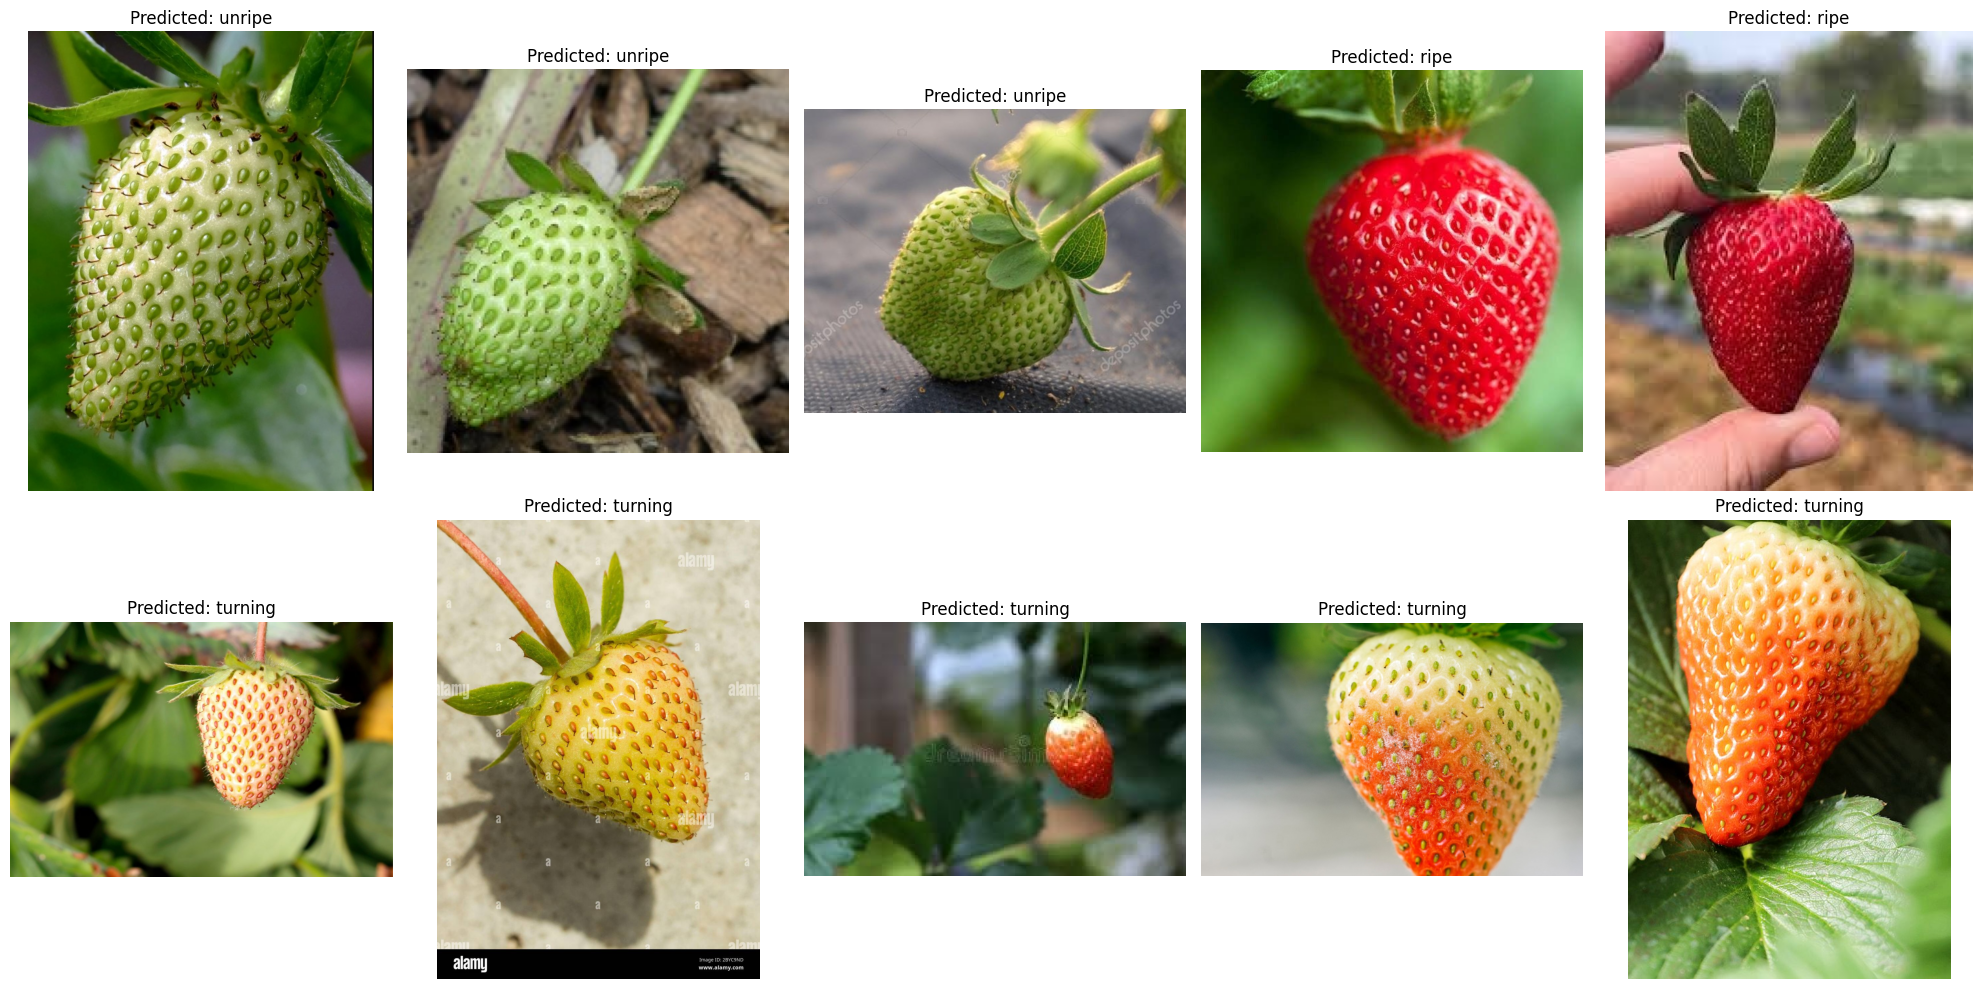

WhatsApp Image 2025-06-19 at 15.28.14_715a6f86.jpg ➜ unripe
WhatsApp Image 2025-06-19 at 15.29.15_02bf5f22.jpg ➜ unripe
WhatsApp Image 2025-06-19 at 15.29.16_502099dd.jpg ➜ unripe
WhatsApp Image 2025-06-19 at 15.30.34_3c2e84ee.jpg ➜ ripe
WhatsApp Image 2025-06-19 at 15.31.04_191842d7.jpg ➜ ripe
WhatsApp Image 2025-06-19 at 15.31.11_09fea1f8.jpg ➜ turning
WhatsApp Image 2025-06-19 at 15.31.50_7c59bcf2.jpg ➜ turning
WhatsApp Image 2025-06-19 at 15.32.00_823093c5.jpg ➜ turning
WhatsApp Image 2025-06-19 at 15.32.54_dd307118.jpg ➜ turning
WhatsApp Image 2025-06-19 at 15.33.12_e5cd64bd.jpg ➜ turning


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os

# Set path to folder containing test images (put 10 test images here)
test_folder = '/content/test_images/'  #  Folder with 10 test images
class_names = ['ripe', 'turning', 'unripe']  #  Modify if needed

# Load model
model = load_model('/content/strawberry.h5')

# Load and preprocess up to 10 images
image_size = (224, 224)
img_arrays = []
img_paths = []

# Collect up to 10 images
for fname in sorted(os.listdir(test_folder))[:10]:
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        path = os.path.join(test_folder, fname)
        img = image.load_img(path, target_size=image_size)
        img_array = image.img_to_array(img) / 255.0
        img_arrays.append(img_array)
        img_paths.append(path)

# Convert to batch array
img_batch = np.array(img_arrays)

# Predict
predictions = model.predict(img_batch)
predicted_classes = np.argmax(predictions, axis=1)

# Plot predictions
plt.figure(figsize=(20, 10))
for i in range(len(img_batch)):
    plt.subplot(2, 5, i + 1)
    img = image.load_img(img_paths[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[predicted_classes[i]]}', fontsize=12)
plt.tight_layout()
plt.show()

# Also print file names and predictions
for path, pred_idx in zip(img_paths, predicted_classes):
    print(f"{os.path.basename(path)} ➜ {class_names[pred_idx]}")


/tmp/ipython-input-26-781872174.py:25: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-26-781872174.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


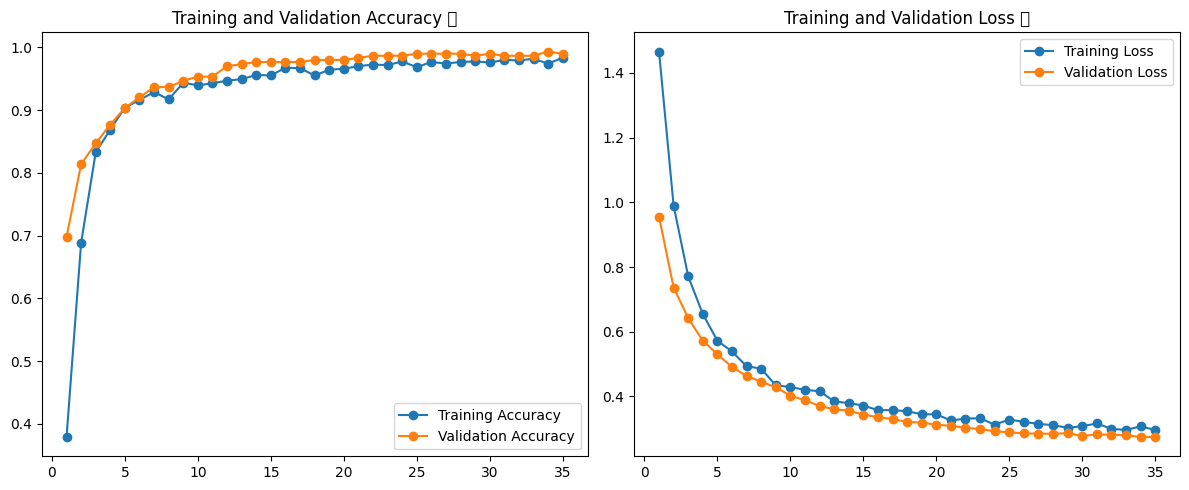

In [26]:
import matplotlib.pyplot as plt
# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy 🎯')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss 📉')

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step
Confusion Matrix:
 [[144   0   0]
 [  0  58   0]
 [  0   3  96]]

Classification Report:
               precision    recall  f1-score   support

        ripe       1.00      1.00      1.00       144
     turning       0.95      1.00      0.97        58
      unripe       1.00      0.97      0.98        99

    accuracy                           0.99       301
   macro avg       0.98      0.99      0.99       301
weighted avg       0.99      0.99      0.99       301


Precision (weighted): 0.9905
Recall (weighted): 0.9900

 Metrics report saved to: /content/metrics_report.txt


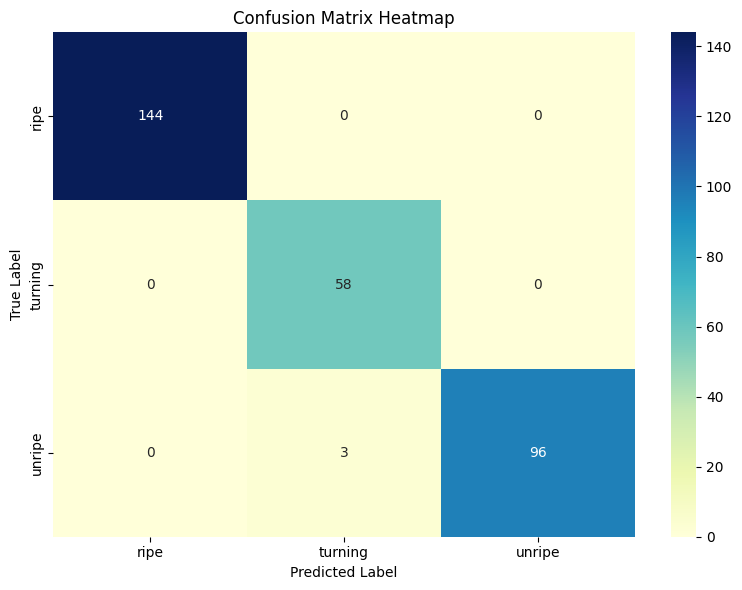

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Get predictions
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
class_report = classification_report(y_true, y_pred, target_names=class_labels)

# Print results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print(f"\nPrecision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# Save to text file
report_path = '/content/metrics_report.txt'
with open(report_path, 'w') as f:
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(conf_matrix))
    f.write("\n\nClassification Report:\n")
    f.write(class_report)
    f.write(f"\n\nPrecision (weighted): {precision:.4f}")
    f.write(f"\nRecall (weighted): {recall:.4f}")

print(f"\n Metrics report saved to: {report_path}")

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Optional: Download the report
files.download(report_path)
